# Seafloor Spreading Bathymetry and Magnetic Anomalies

**Last week we:**
- Loaded and visualized an earthquake catalog.
- Plotted earthquake magnitude and depth.
- Learned some more complicated mapping techinque. 

**Our goals for today:**
- Practice pandas DataFrames, indexing, and data cleaning.
- Load marine geophysical data (bathymetry and marine magnetic anomalies) from two oceanic ridges.
- Select data and drop rows with gaps.
- Plot bathymetry data and evaluate spreading rate.
- Declare a function to detrend magnetic anomaly data.
- Plot marine magnetic anomaly data and compare spreading rates.


## Setup

Run this cell as it is to setup your environment.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cartopy import config
import cartopy.crs as ccrs
from scipy import signal
import scipy as sc

## Marine Geology, Bathymetry and Magnetic Anomalies

We'll look at marine magnetics and bathymetry data from two surveys, from the Mid-Atlantic Ridge and East Pacific Rise.

This video gives a very nice overview of the concepts of continental drift, sea floor spreading and the magnetic striping anomalies that we will examine in this notebook: https://youtu.be/JJEZ3Vizdww

First we'll load the Atlantic data (that can be accessed here: https://maps.ngdc.noaa.gov/viewers/geophysics/), and then we'll need to clean them up.

In [4]:
# Load the seafloor depth, marine mag anom data
#columns ['SURVEY_ID','TIMEZONE','DATE','TIME','LAT','LON','POS_TYPE','NAV_QUALCO','BAT_TTIME','CORR_DEPTH','BAT_CPCO','BAT_TYPCO','BAT_QUALCO','MAG_TOT','MAG_TOT2','MAG_RES','MAG_RESSEN','MAG_DICORR','MAG_SDEPTH','MAG_QUALCO','GRA_OBS','EOTVOS','FREEAIR','GRA_QUALCO','LINEID','POINTID']

vanc05mv_data_file = pd.read_table('./data_tracks/vanc05mv.m77t')
atlantic_data = vanc05mv_data_file.drop(columns=['SURVEY_ID','TIMEZONE','DATE','TIME','POS_TYPE','NAV_QUALCO',
                                                 'BAT_TTIME','BAT_CPCO','BAT_TYPCO','BAT_QUALCO','MAG_TOT2','MAG_RES',
                                                 'MAG_RESSEN','MAG_DICORR','MAG_SDEPTH','MAG_QUALCO','GRA_OBS','EOTVOS',
                                                 'FREEAIR','GRA_QUALCO','LINEID','POINTID'])
#Compare original and trimmed dataframes using .head()


In [5]:
#Use .describe() to examine the data

Notice that some entries do not have either depth, magnetization  or both and instead in those fields `'NaN'` (not a number) is specified. We'll use `~np.isnan` to select rows were we have depth AND magnetic field measurements. The function np.isnan() identifies NaN entries returning cases that have NaNs. note that in the following the complement (~) is used in the logial expression, leaving only rows that have BOTH CORR_DEPTH and MAG_TOT specified.


In [7]:
#discuss the structure of the boolean logical test
atlantic_data_clean = atlantic_data[~np.isnan(atlantic_data['CORR_DEPTH']) &  ~np.isnan(atlantic_data['MAG_TOT'])];
#atlantic_data_clean.head()

In [6]:
#atlantic_data_clean.describe()

Let's take a look at our data!

<font color=goldenrod>**_Code for you to write_**</font>

**Plot atlantic_data on a map and make it have a linewidth of 2 and a color of orange**

**Plot atlantic_data_clean on the same map and make it have a linewidth of 4 and a color of red**

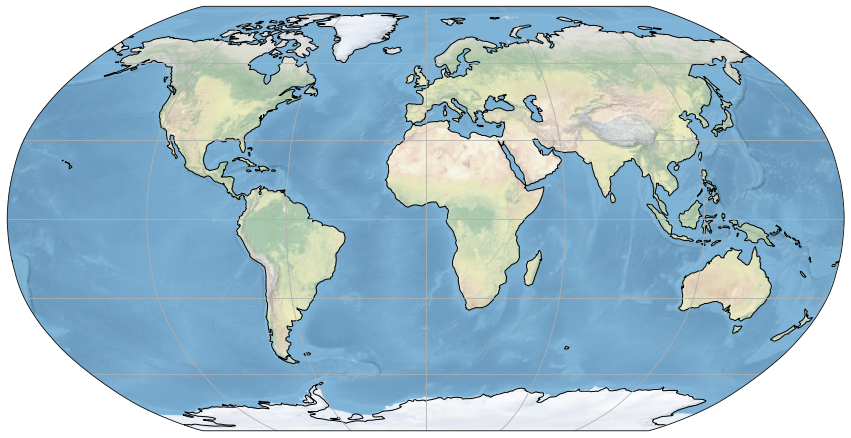

In [9]:
plt.figure(1,(15,15))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()

#ax.plot(ADD_CODE_HERE, transform=ccrs.PlateCarree())
#ax.plot(ADD_CODE_HERE,transform=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
ax.gridlines()

plt.show()

Next we want to plot the clean data in profile

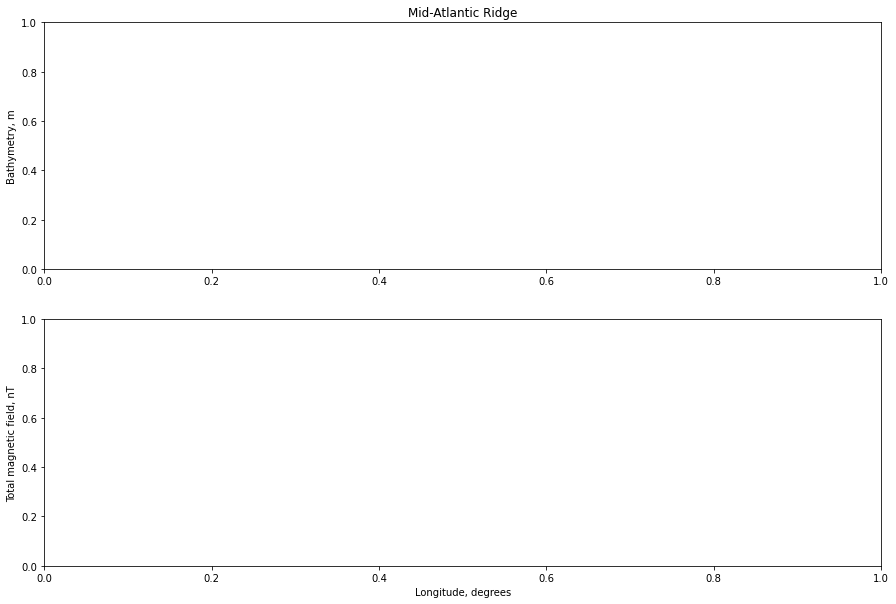

In [11]:
plt.figure(1,(15,10))
ax1=plt.subplot(2, 1, 1)
#ax1.plot(..., ..., color='mediumblue');
ax1.set_ylabel('Bathymetry, m');
ax1.set_title('Mid-Atlantic Ridge')

ax2=plt.subplot(2, 1, 2)
#ax2.plot(..., ..., color='mediumblue');
ax2.set_xlabel('Longitude, degrees');
ax2.set_ylabel('Total magnetic field, nT');

Let's just analyze the portion of the survey from around the ridge, so from longitudes -24.0 to 0.0 degrees. So use Boolean indexing to pull out rows of `atlantic_data_clean` where `atlantic_data_clean['LON']` is between those values.

<font color=goldenrod>**_Code for you to write_**</font>

In [13]:
#atlantic_data_cropped = atlantic_data_clean[...]

Here's a map of where our survey line was collected with a grid of seafloor bathymetry in the background.

<img src="Figures/MAR_track_map.png" width=900>

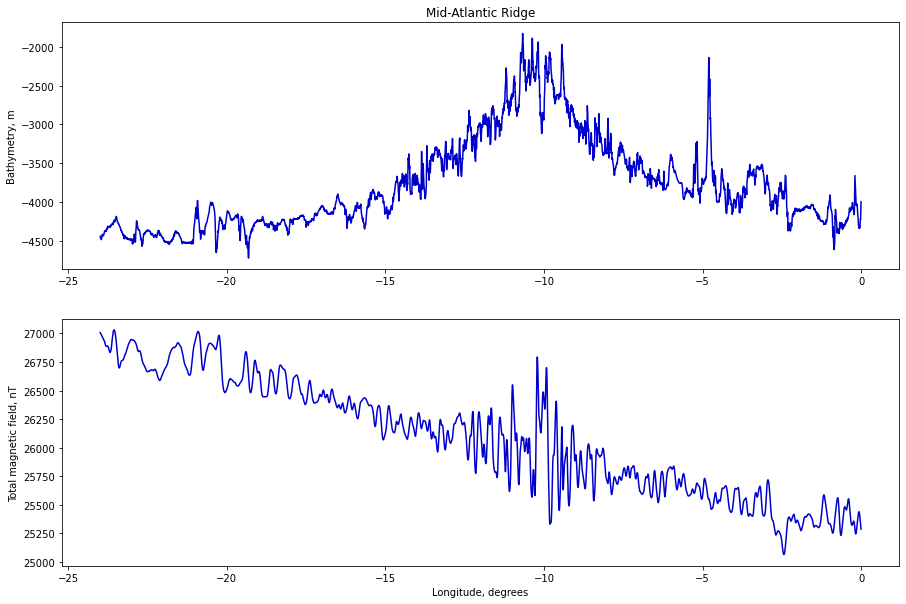

In [9]:
plt.figure(1,(15,10))
ax1=plt.subplot(2, 1, 1)
ax1.plot(atlantic_data_cropped['LON'],-1*atlantic_data_cropped['CORR_DEPTH'],color='mediumblue');
ax1.set_ylabel('Bathymetry, m');
ax1.set_title('Mid-Atlantic Ridge')

ax2=plt.subplot(2, 1, 2)
ax2.plot(atlantic_data_cropped['LON'],atlantic_data_cropped['MAG_TOT'],color='mediumblue');
ax2.set_xlabel('Longitude, degrees');
ax2.set_ylabel('Total magnetic field, nT');

We need to convert the position of the lat,lon magnetic track into a distance magnetic track referenced to the position of the spreading center. The position of the spreading center is assigned a distance of zero.  Since the data is already presented as a track we can simply find the distance of lat,lon points along the track relative to the ridge position. To start we create numpy arrays of lat, lon, bathymetry and magnetic intensity. We then use the haversine function defined in the next cell to compute the distance between two points on a sphere.

In [10]:
#We need a function to calculate distance between two points on a sphere. 
#Functions (or subroutines) are a good way to compartmentalize code for repeated operations
#DO NOT EDIT THIS CELL BUT DO READ THROUGH IT TO UNDERSTAND CONSTRUCTION
def haversine_np(lon1, lat1, lon2, lat2):
    """
    A FUNCTION SHOULD HAVE A COMMENT BLOCK THAT STATES INPUT PARAMETERS AND UNITS AND OUTPUT PARAMETERS AND UNITS
    AS WELL AS DESCRIBE WHAT IT DOES
    
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length. i.e. floating point number, or arrays of numbers of equal length
    
    latitude and longitude arguments are input as decimal degrees
    
    output is distance in km
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    
    signfac=-dlon/np.abs(dlon)  #note the minus is because the difference of smaller number is positive
    km = 6371 * c * signfac
    return km

In [11]:
#Specify the position of the ridge
ridgelon=np.float(-10.07)
tmp=np.array(atlantic_data_cropped['LAT'][np.abs(atlantic_data_cropped['LON'] - ridgelon) < 0.01])
ridgelat=tmp[0]

#Convert data to numpy arrays
atl_lat=np.array(atlantic_data_cropped['LAT'])
atl_lon=np.array(atlantic_data_cropped['LON'])
atl_bath=np.array(atlantic_data_cropped['CORR_DEPTH'])
atl_mag=np.array(atlantic_data_cropped['MAG_TOT'])

#create lat2, lon2 arrays of the ridge position. We do this to take advantage of the speed of vector arithmatic in python.
lat2=np.ones(len(atl_lat))*ridgelat
lon2=np.ones(len(atl_lat))*ridgelon
atl_dist=haversine_np(atl_lon,atl_lat,lon2,lat2)

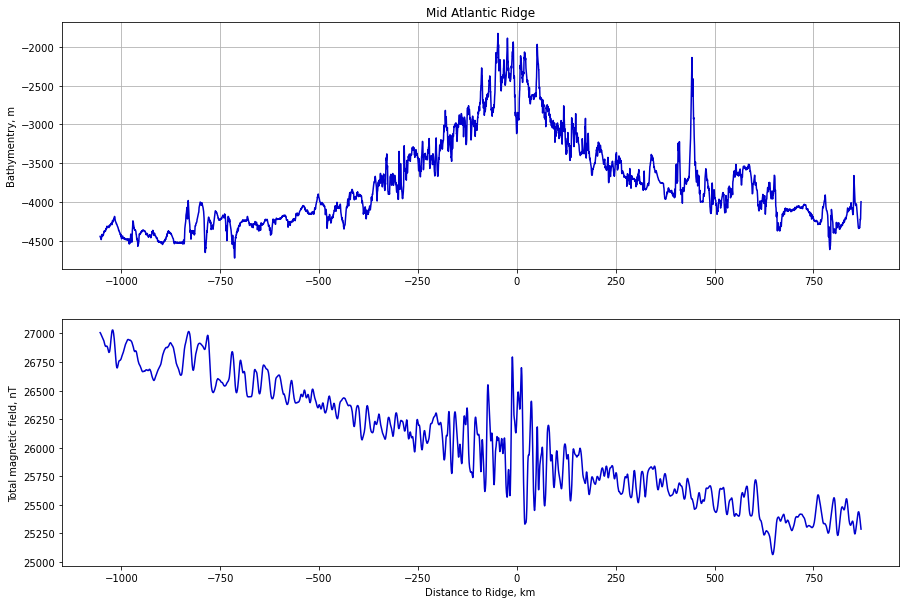

In [12]:
#Plot the bathymetry and magnetic field data
plt.figure(1,(15,10))
ax1=plt.subplot(2, 1, 1)
ax1.plot(atl_dist,-1*atl_bath,color='mediumblue');
ax1.grid()
ax1.set_title('Mid Atlantic Ridge')
ax1.set_ylabel('Bathymentry, m');

ax2=plt.subplot(2, 1, 2)
ax2.plot(atl_dist,atl_mag,color='mediumblue');
ax2.set_xlabel('Distance to Ridge, km');
ax2.set_ylabel('Total magnetic field, nT');
plt.show()

### Next lets load a data set for the East Pacific rise to compare with

In [13]:
# Load the seafloor depth, marine mag anom data
# Source: https://maps.ngdc.noaa.gov/viewers/geophysics/
#names=['SURVEY_ID','TIMEZONE','DATE','TIME','LAT','LON','POS_TYPE','NAV_QUALCO','BAT_TTIME','CORR_DEPTH','BAT_CPCO','BAT_TYPCO','BAT_QUALCO','MAG_TOT','MAG_TOT2','MAG_RES','MAG_RESSEN','MAG_DICORR','MAG_SDEPTH','MAG_QUALCO','GRA_OBS','EOTVOS','FREEAIR','GRA_QUALCO','LINEID','POINTID'])

nbp9707_data_file=pd.read_table('data_tracks/nbp9707.m77t')
pacific_data = nbp9707_data_file.drop(columns=['SURVEY_ID','TIMEZONE','DATE','TIME','POS_TYPE','NAV_QUALCO','BAT_TTIME','BAT_CPCO','BAT_TYPCO','BAT_QUALCO','MAG_TOT2','MAG_RES','MAG_RESSEN','MAG_DICORR','MAG_SDEPTH','MAG_QUALCO','GRA_OBS','EOTVOS','FREEAIR','GRA_QUALCO','LINEID','POINTID'])

pacific_data_clean = pacific_data[~np.isnan(pacific_data['CORR_DEPTH']) &  ~np.isnan(pacific_data['MAG_TOT'])]; #use ~np.isnan to clear out rows were there are nans
pacific_data_cropped = pacific_data_clean[(pacific_data_clean['LON']>-126.0) & (pacific_data_clean['LON']<-95.0)] # use Boolean indexing to select rows with Longitude -126 deg to -95 deg

Here's a map of where our survey line was collected with a grid of seafloor bathymetry in the background.

<img src="Figures/EPR_track_map.png" width=900>

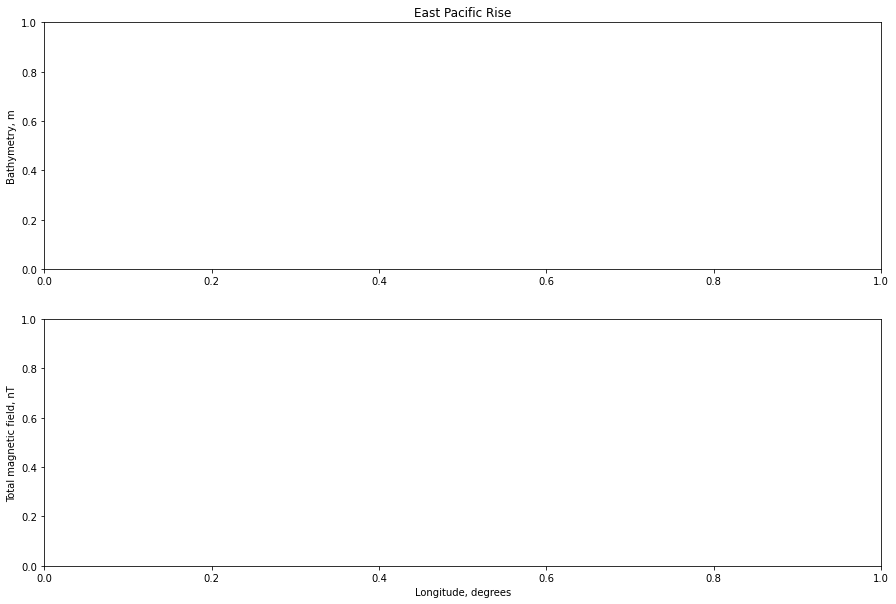

In [14]:
plt.figure(1,(15,10))
ax1=plt.subplot(2, 1, 1)
#ax1.plot(pacific_data_cropped['LON'],-1*pacific_data_cropped['CORR_DEPTH'],color='blue')
ax1.set_ylabel('Bathymetry, m')
ax1.set_title('East Pacific Rise')

ax2=plt.subplot(2, 1, 2)
#ax2.plot(pacific_data_cropped['LON'],pacific_data_cropped['MAG_TOT'],color='blue')
ax2.set_xlabel('Longitude, degrees')
ax2.set_ylabel('Total magnetic field, nT')
plt.show()

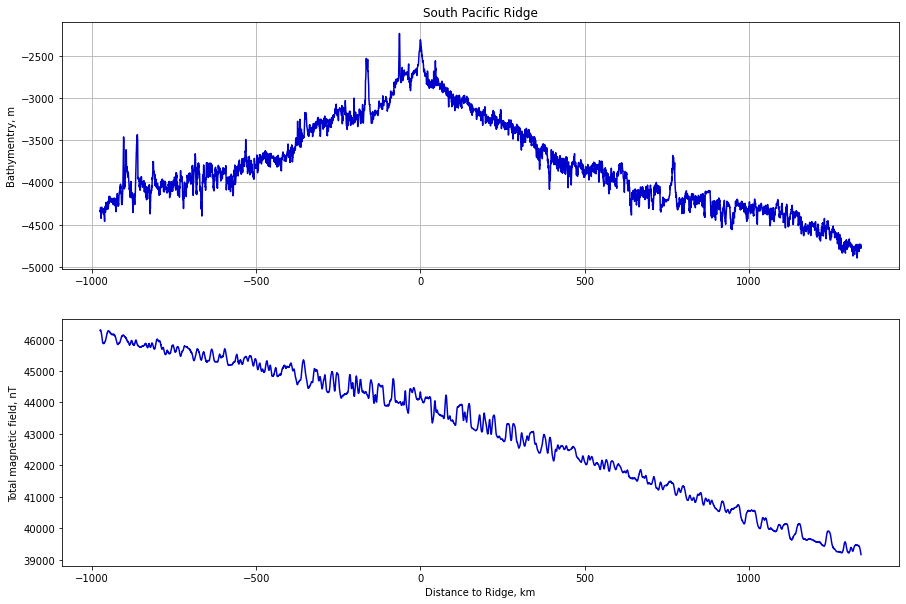

In [15]:
#Specify the position of the ridge
ridgelon=np.float(-113.521)
tmp=np.array(pacific_data_cropped['LAT'][np.abs(pacific_data_cropped['LON'] - ridgelon) < 0.01])
ridgelat=tmp[0]

#Convert data to numpy arrays
pac_lat=np.array(pacific_data_cropped['LAT'])
pac_lon=np.array(pacific_data_cropped['LON'])
pac_bath=np.array(pacific_data_cropped['CORR_DEPTH'])
pac_mag=np.array(pacific_data_cropped['MAG_TOT'])

#create lat2, lon2 arrays of the ridge position. We do this to take advantage of the speed of vector arithmatic in python.
lat2=np.ones(len(pac_lat))*ridgelat
lon2=np.ones(len(pac_lat))*ridgelon
pac_dist=haversine_np(pac_lon,pac_lat,lon2,lat2)

plt.figure(1,(15,10))
ax1=plt.subplot(2, 1, 1)
ax1.plot(pac_dist,-1*pac_bath,color='mediumblue');
ax1.set_title('South Pacific Ridge')
ax1.set_ylabel('Bathymentry, m');
ax1.grid()

ax2=plt.subplot(2, 1, 2)
ax2.plot(pac_dist,pac_mag,color='mediumblue');
ax2.set_xlabel('Distance to Ridge, km');
ax2.set_ylabel('Total magnetic field, nT');

### Bathymetry

Now let's compare the two ridges' bathymetry. 

Let's plot them together on one figure as subplots. Use $\pm 1000$ km as the x-axis limits and -5000 to -1500 meters as the y-axis limits for both ridges. Syntax set_xlim(xxx, xxx)

<font color=goldenrod>**_Code for you to write_**</font>

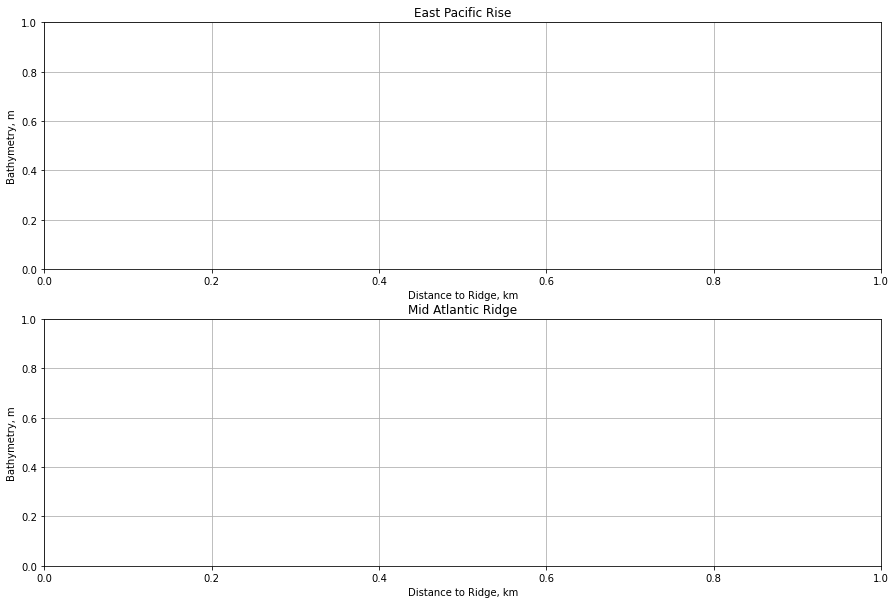

In [16]:
plt.figure(1,(15,10))
ax1 = plt.subplot(2,1,1)
#add code here
ax1.set_xlabel('Distance to Ridge, km') # labels!
ax1.set_ylabel('Bathymetry, m')
ax1.set_title('East Pacific Rise')
ax1.grid()

ax2 = plt.subplot(2,1,2)
#add code here
ax2.set_xlabel('Distance to Ridge, km')
ax2.set_ylabel('Bathymetry, m')
ax2.set_title('Mid Atlantic Ridge')
ax2.grid()

#plt.tight_layout()

<img src="Figures/spreading_ridges.png" width=900>
> Source: Essentials of Geology (13th Edition) Lutgens, Tarbuck, and Tasa.

**Discussion Questions:** What do you observe in the bathymetry? Do these ridges have a rift valley at the center? Is the slope steep or gentle? Is the bathymetry rough or smooth?

**Write your answer here.**

Based on the ridge bathymetry, which spreading center do you think is spreading faster the Atlantic or Pacific?

**Write your answer here.**

### Crustal Magnetic Field

Now let's compare their marine magnetic field data.

Make a plot of the magnetic field from each ridge (['MAG_TOT']). Follow the code above for the bathymetry. Be sure to include axis labels.

```
ax2.set_xlabel('Distance to Ridge, km');
ax2.set_ylabel('Total Field, nT');
ax2.set_title('Mid Atlantic Ridge');
```

<font color=goldenrod>**_Code for you to write_**</font>

In [17]:
#Make plots comparing Atlantic and Pacific Magnetic Anomalies here

### Write code to remove polynomial fit and plot the East Pacific and Atlantic Magnetic Anomalies

There are long wavelength drifts in the magnetic data due to noise, and diurnal (daily) variation. The diurnal varation arises due to daily fluctuations in the ionosphere. Another type of drift that occurs over years and decades is secular drift and and is due to actual changes in the generated field within the earth.

We want to remove these trends or drifts. Inspection of the data reveals linear, or perhaps higher order polynomial trends. This is a two step process where first we fit a model to the data, and then we remove the predictions of the model to reveal anomalies. We will use the numpy polyfit() to determine model coefficients (a, b, etc). Then we will use numpy poly1d() to estimate the model for each independent variable to construct an array of model values to remove from the data. Let's write a function to do that.

$Y=a + bX + cX^2 + dX^3 + etc.$

Plot the marine magnetic anomalies together as subplots again with reference lines at zero nT, and zoom in the `xlim` to $\pm$100 km and add a grid with xticks every 10 km using `ax1.set_xticks(np.arange(-100,100,10))`.

<font color=goldenrod>**_Code for you to write_**</font>

In [30]:
def data_detrend(dist_values, mag_values, poly_order):
    """
    function to fit a polynomial to data, and then remove the fitted polynomial leaving the residual or anomaly
    dist_values are in km
    mag_values in nT
    poly_order integers 0 (mean), 1 (line), 2 (parabola), 3, etc.
    
    model is an array of modeled data, and anomaly is an array corrected data
    
    usage:
    array1, array2, value=data_detrend(dist_values, mag_values, poly_order)
    """
    a=np.polyfit(dist_values,mag_values,poly_order)   #This finds the coefficients for polynomial of specified order
    b=np.poly1d(a)                                    #This finds a function from which to determine model values
    model=b(dist_values)                              #model array
    anomaly=mag_values - model                        #anomaly array of data corrected by the model
    
    #RMS error
    rms=np.sqrt(np.mean(anomaly**2))
    
    return model, anomaly, rms

We want to compare the original data with the polynomial fit. We then want to test different values of the fit to find the best, and then remove the polynomial trend from the data.

First, lets plot the data together with the polynomial fit

<font color=goldenrod>**_Code for you to write_**</font>

In [19]:
#Plot the model fit and find the simplest model that provides a good fit.



Now plot the corrected data with the polynomial trend removed. Include a zero reference line: `plot([x1, x2],[y1, y2],color='black')`

Consider distance ranges of -100 to 100 and -200 to 200. Consider putting in xticks every 10 km `ax1.set_xticks(np.arange(-200,200,10))`

<font color=goldenrod>**_Code for you to write_**</font>

In [20]:
#Plot the anomally Note you may or may not use different polynomial order for the two different data sets.



<img src="Figures/marine_mag_anom.png" width=900>
> Source: Fundamentals of Geophysics (2nd Edition) Lowrie, W.

Which wiggles can you match between lines and to the model profile due to the GPTS above? Can you pick the Bruhnes, Matuyama, Gauss, and Gilbet polarity chrons? What distance from the ridge does the Bruhnes-Matuyama reversal (which tells us an age of 776 kyr) occur at for both ridges? Zoom in on your plots and write down the distance to the ridge.

**Write your answer here.**

Define a function that you can use to calculate the spreading rate in km/Myr using the distance from the ridge of the Bruhnes-Matuyama reversal. The function should take the distance to the reversal as input and return a spreading rate. An important piece of information is that the reversal occurred 776,000 years ago (Singer et al. 2019). Make sure that the function has a docstring and that the docstring indicates what units the calculated rate is in.

You can find helpful information about functions here (part of your weekly reading): https://www.inferentialthinking.com/chapters/08/Functions_and_Tables.html

<font color=goldenrod>**_Code for you to write_**</font>

In [22]:
def spread_rate(dist,age):
    """
    Function to compute the spreading rate
    
    parameters
    ----------
    dist: distance to the ridge in km
    age: age of the reversal in Myr
    
    output
    ------
    rate: spreading rate in km/Myr
    """
    # write your code here
    
    return 

Use your function to compute the spreading rate of the atlantic and pacific ridges. Print the results.

Based on the marine magnetic anomalies, which spreading center do you think is spreading faster the Atlantic or Pacific? Is that consistent with your estimate from the bathymetry?

**Write your answer here.**

### Turn in this notebook

Save your completed notebook as a pdf and upload to bcourses.